For the first model, we use features extracted out of the `events` dataset, which we think is the most important dataset among the 4. After getting feature importance out of the first model, which hopefully sheds light on what other features might be helpful, we will extract more features from the other datasets and add them to the model.

# Week 1

We run the following code for 3 files:
* The entire `events` dataset including all days for all users for prediction.
* The `events_before_7` dataset including days except for the last 7 days.
* The `events_before_14` dataset including days except for the last 14 days.

The features that we extract out of `events` data are:

<img src="features.png" width=80%/>

As the prediction is on user level, we extract features for each user by grouping the raw data set by `user_id_hash`, aggregating per user, and storing clean data of the features in `df_clean` dataframe.

__Read data in__

In [1]:
import datetime
from datetime import timedelta
import feather
import pandas as pd
import numpy as np
import time

In [35]:
event_file = './Data/events.csv'
# event_file = './Data/events_before_7.csv'
# event_file = './Data/events_before_14.csv'
event_types = {'session_id': np.uint64, 'event':'category', 
               'event_timestamp':str, 'event_value':str, 'user_id_hash':'category'}
df = pd.read_csv(event_file, usecols=event_types.keys(), dtype=event_types)
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], utc=True, unit='ms')
df.head(5)

,session_id,event,event_timestamp,event_value,user_id_hash
0,5558845121177764917,45,1542215397132,0.0,9943447915df3a45fd6720a026af905b6da6b56a37701b...
1,5558845121177764917,45,1542215484895,0.0,9943447915df3a45fd6720a026af905b6da6b56a37701b...
2,7689508378645584666,.m5100869650219008,1541124410372,0.0,9943447915df3a45fd6720a026af905b6da6b56a37701b...
3,2201961907282901522,4,1543713091129,0.0,9943447915df3a45fd6720a026af905b6da6b56a37701b...
4,2201961907282901522,6,1543713093116,0.0,9943447915df3a45fd6720a026af905b6da6b56a37701b...


In [3]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97805216 entries, 0 to 97805215
Data columns (total 5 columns):
session_id         uint64
event              category
event_timestamp    object
event_value        object
user_id_hash       category
dtypes: category(2), object(2), uint64(1)
memory usage: 13.1 GB


__Extract features__

In [4]:
df_clean = pd.DataFrame()

In [6]:
df_clean['num_session'] = df.groupby('user_id_hash')['session_id'].apply(lambda x: len(x.unique()))

In [8]:
last_date = df['event_timestamp'].max()
df_clean['last_active'] = df.groupby('user_id_hash')['event_timestamp'].apply(lambda x: (last_date - max(x)).days)
print('Done')

Done


In [11]:
# number of message
def count_messages(x):  # x is the pd.Series of all events an user
    message = [e for e in x if e[:2]=='.m']
    return len(message)

start = time.time()
df_clean['receive_message'] = df.groupby('user_id_hash')['event'].apply(count_messages)
print("Time extracting this feature: {}".format(time.time()-start))

Time extracting this feature: 569.7112472057343


In [14]:
# How many messages an user accepts (how responsive they are to messages)
def accept_message(x):
    acc = [e for e in x if 'Accept' in e]
    return len(acc)

start = time.time()
df_clean['accept_message'] = df.groupby('user_id_hash')['event'].apply(accept_message)
print("Time extracting this feature in minutes: {}".format((time.time()-start)/60))

Time extracting this feature in minutes: 3.784253803888957


In [15]:
# life time value
def compute_ltv(df):
    return df[df['event']=='8']['event_value'].astype(float).sum()

start = time.time()
df_clean['life_time_value'] = df.groupby('user_id_hash').apply(compute_ltv)
print("Time extracting this feature in minutes: {}".format((time.time()-start)/60))

Time extracting this feature in minutes: 45.858204646905264


In [16]:
# number of purchases
def count_purchase(df):
    # df is the DataFrameGroupBy by user_id_hash
    return df[df['event']=='8'].shape[0]

df_clean['num_purchase'] = df.groupby('user_id_hash').apply(count_purchase)

In [17]:
def average_purchase(row):
    if row['life_time_value'] == 0:
        return 0
    else:
        return row['life_time_value']/row['num_purchase']

start = time.time()
df_clean['avg_purchase'] = df_clean.apply(average_purchase, axis=1)
print("Time extracting this feature in minutes: {}".format((time.time()-start)/60))

Time extracting this feature in minutes: 0.3049905021985372


In [19]:
start = time.time()
df_clean['num_event'] = df.groupby('user_id_hash')['event'].apply(len)
print("Time extracting this feature: {}".format(time.time()-start))

Time extracting this feature: 122.37881588935852


In [20]:
start = time.time()
df_clean['event_per_session'] = df_clean['num_event']/df_clean['num_session']
print("Time extracting this feature in minutes: {}".format((time.time()-start)/60))

Time extracting this feature in minutes: 0.00232311487197876


In [21]:
df_clean.reset_index().head(2).T

,0,1
user_id_hash,002e447aed33ed4c51a68743cc293ef2148058b6a6239e...,005c9d79cf18efc6c8b5fa767964b1def9b8e2f8abd23f...
num_session,3,2
last_active,26,42
receive_message,0,0
accept_message,0,0
life_time_value,0,0
num_purchase,0,0
avg_purchase,0,0
num_event,119,24
event_per_session,39.6667,12


In [22]:
feather.write_dataframe(df_clean.reset_index(), 'Data/features_before_14.feather')

# Week 2

Realizing that using good features is the defining factor to improve the performance of the model, our next step is to finetune features we already have and extract new features:

* For last_active, num_session, event_per_session: we will take into account the fact that not all sessions are initiated by users and exclude them when computing these features. 

* Also, we extract new features: last_time_purchase as well as last time an user had a certain event (the underlying assumption is that there might be an event that has strong correlation with purchase such as checking a promotional code), "app age" of users (how much time they have used the app), and the number of devices they have (hinting how involved they are with the app).

## Extract features related to last time an user had an event

An interesting finding from the initial model we have is that `last_active` is the major feature that drives the performance of our model. This inspires us to extract similar features such last `last_purchase` and the last time an user did an event.

In [27]:
df_ft = feather.read_dataframe('./Data/features_v1.feather').set_index('user_id_hash')

In [28]:
df_ft.head(5)

,num_session,last_active,receive_message,accept_message,life_time_value,num_purchase,avg_purchase,num_event,event_per_session
user_id_hash,,,,,,,,,
002e447aed33ed4c51a68743cc293ef2148058b6a6239e37d013cc6dc49bdfdf,3,40,0,0,0.0,0,0.0,119,39.666667
005c9d79cf18efc6c8b5fa767964b1def9b8e2f8abd23f453310f60d69584a9f,2,56,0,0,0.0,0,0.0,24,12.000000
0061b4d30e8a9935b2ebeec954ff509b4f0cb500cd725c1aa7145841c82d907c,1,68,0,0,0.0,0,0.0,34,34.000000
00fbbf507c7d3c2f259cd3329d241c29d35712e2d4699f5c6a51d5149219ecee,3,65,0,0,0.0,0,0.0,47,15.666667
0107a0017873efc2dea9a9155832363ceacf6fe97bd428a73efa67b639962ac0,1,53,0,0,0.0,0,0.0,14,14.000000


In [36]:
# event_file = './Data/events.csv'
# event_file = './Data/events_before_7.csv'
event_file = './Data/events_before_14.csv'

event_types = {'session_id': np.uint64, 
               'event':'category', 
               'event_value': str, 
               'user_id_hash':'category', 
               'event_timestamp':str}

df_raw = pd.read_csv(event_file, usecols=event_types.keys(), dtype=event_types, index_col=['user_id_hash'])

In [9]:
df_raw['event_timestamp'] = pd.to_datetime(df_raw['event_timestamp'], utc=True, unit='ms')

In [14]:
last_date = df_raw['event_timestamp'].max()  # the cut off for this period
last_date

Timestamp('2018-12-14 23:59:59.977000+0000', tz='UTC')

In [15]:
def extract_last_purchase(x, last_date):  #x is a GroupByDataFrame
    last_purchase_date = x[x['event']=="8"]['event_timestamp'].max()
#     if last_purchase_date == None:
#         return -1
    return (last_date - last_purchase_date).days

In [21]:
df_ft['last_purchase'] = df_raw.groupby('user_id_hash').apply(lambda x: extract_last_purchase(x, last_date))


In [22]:
df_ft['last_purchase'].fillna(-1, inplace=True)

In [23]:
# df_ft.tail(5)

In [24]:
feather.write_dataframe(df_ft.reset_index(), './Data/features_v2.feather')

### Extraction for similar features for all events

We extracted features named in this format `last_date_event_i` where i is the event. Now we're combining with other features.

In [42]:
cut_off_all = pd.to_datetime('2018-12-14 23:59:59.977000+0000', utc=True)
cut_off_7 = pd.to_datetime('2018-12-07 23:59:59.977000+00:00', utc=True)
cut_off_14 = pd.to_datetime('2018-11-30 23:59:59.977000+00:00', utc=True)

In [69]:
df_ft = feather.read_dataframe('./Data/features_v1.feather').set_index('user_id_hash')
df_ft.head(5)

,num_session,last_active,receive_message,accept_message,life_time_value,num_purchase,avg_purchase,num_event,event_per_session
user_id_hash,,,,,,,,,
002e447aed33ed4c51a68743cc293ef2148058b6a6239e37d013cc6dc49bdfdf,3,40,0,0,0.0,0,0.0,119,39.666667
005c9d79cf18efc6c8b5fa767964b1def9b8e2f8abd23f453310f60d69584a9f,2,56,0,0,0.0,0,0.0,24,12.000000
0061b4d30e8a9935b2ebeec954ff509b4f0cb500cd725c1aa7145841c82d907c,1,68,0,0,0.0,0,0.0,34,34.000000
00fbbf507c7d3c2f259cd3329d241c29d35712e2d4699f5c6a51d5149219ecee,3,65,0,0,0.0,0,0.0,47,15.666667
0107a0017873efc2dea9a9155832363ceacf6fe97bd428a73efa67b639962ac0,1,53,0,0,0.0,0,0.0,14,14.000000


In [70]:
last_date_all_events = pd.read_csv('./Data/testbed/last_date_data_all.csv')
last_date_all_events.head(5)

,user_id_hash,last_date_event_0,last_date_event_1,last_date_event_10,last_date_event_11,last_date_event_14,last_date_event_3,last_date_event_32,last_date_event_4,last_date_event_40,...,last_date_event_59,last_date_event_6,last_date_event_60,last_date_event_61,last_date_event_62,last_date_event_63,last_date_event_64,last_date_event_7,last_date_event_8,last_date_event_9
0,2fafe81d1fa7b1a7333e587c4be22b595e76650b0e7089...,1.540540e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,fc695d7339dc3f3b7981fbd3f6c266084980b08f515b2f...,NaN,1.541290e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1ac8de3edd209fa1b205f96a66ae5035456d59ad205638...,1.541063e+12,1.540802e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f5c9fff021057131db3a90a50b077f1abdf3f127130401...,NaN,1.538625e+12,NaN,NaN,1.538625e+12,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.538625e+12,NaN,NaN
4,1f4a7a9c1622ab0cdb11aaad4df3b4f1c3e7198d08fd1c...,1.540284e+12,1.539721e+12,NaN,NaN,1.539721e+12,1.539720e+12,NaN,1.539720e+12,1.539720e+12,...,NaN,1.539720e+12,NaN,NaN,NaN,NaN,NaN,1.539719e+12,NaN,NaN


In [71]:
# parse dates and compute timedelta
def compute_delta(x, cut_off):
    if x == None:
        return None
    return (cut_off-x).days

for col in last_date_all_events.columns[1:]:
    print(f'Processing {col}')
    last_date_all_events[col] = pd.to_datetime(last_date_all_events[col], utc=True, unit='ms')
    last_date_all_events[col] = last_date_all_events[col].apply(lambda x: compute_delta(x, cut_off_all))

Processing last_date_event_0
Processing last_date_event_1
Processing last_date_event_10
Processing last_date_event_11
Processing last_date_event_14
Processing last_date_event_3
Processing last_date_event_32
Processing last_date_event_4
Processing last_date_event_40
Processing last_date_event_41
Processing last_date_event_42
Processing last_date_event_43
Processing last_date_event_44
Processing last_date_event_45
Processing last_date_event_47
Processing last_date_event_48
Processing last_date_event_49
Processing last_date_event_5
Processing last_date_event_50
Processing last_date_event_51
Processing last_date_event_52
Processing last_date_event_54
Processing last_date_event_55
Processing last_date_event_56
Processing last_date_event_57
Processing last_date_event_58
Processing last_date_event_59
Processing last_date_event_6
Processing last_date_event_60
Processing last_date_event_61
Processing last_date_event_62
Processing last_date_event_63
Processing last_date_event_64
Processing last_

In [72]:
df_ft = df_ft.join(last_date_all_events.set_index('user_id_hash'))
df_ft.fillna(-1, inplace=True)  # some events have NaN because we filter out .m, .a, and .c events

In [74]:
df_ft.head(5).T

user_id_hash,002e447aed33ed4c51a68743cc293ef2148058b6a6239e37d013cc6dc49bdfdf,005c9d79cf18efc6c8b5fa767964b1def9b8e2f8abd23f453310f60d69584a9f,0061b4d30e8a9935b2ebeec954ff509b4f0cb500cd725c1aa7145841c82d907c,00fbbf507c7d3c2f259cd3329d241c29d35712e2d4699f5c6a51d5149219ecee,0107a0017873efc2dea9a9155832363ceacf6fe97bd428a73efa67b639962ac0
num_session,3.000000,2.0,1.0,3.000000,1.0
last_active,40.000000,56.0,68.0,65.000000,53.0
receive_message,0.000000,0.0,0.0,0.000000,0.0
accept_message,0.000000,0.0,0.0,0.000000,0.0
life_time_value,0.000000,0.0,0.0,0.000000,0.0
num_purchase,0.000000,0.0,0.0,0.000000,0.0
avg_purchase,0.000000,0.0,0.0,0.000000,0.0
num_event,119.000000,24.0,34.0,47.000000,14.0
event_per_session,39.666667,12.0,34.0,15.666667,14.0
last_date_event_0,-1.000000,56.0,-1.0,65.000000,-1.0


In [89]:
feather.write_dataframe(df_ft.reset_index().rename(columns={'last_date_event_8':'last_purchase'}), 
                        './Data/features_w_events.feather')

## New features from sessions dataset

__First we filter out sessions that are initiated by the system rather than users themselves and filter out developers__

In [2]:
sessions_types = {
    "session_id":np.uint64,
    "is_session": np.bool_,
    "is_developer": np.bool_,
    "country": 'category',
    "region": 'category',
    "city": 'category',
    "locale": 'category',
    "start_timestamp": str,
    "previous_sessions_duration": np.uint64,
    "user_created_timestamp": str,
    "is_user_first_session": np.bool_,
    "session_index": np.uint16,
    "device_id": "category",
    "user_id_hash": "category"}

df_s = pd.read_csv('./Data/sessions.csv', usecols=sessions_types.keys(), dtype=sessions_types)

In [3]:
df_s = df_s[df_s['is_session']==True]
df_s.shape

(5167542, 14)

In [4]:
df_s = df_s[df_s['is_developer']==False]
df_s.shape

(5165760, 14)

In [54]:
# feather.write_dataframe(df_s.drop(['is_session', 'is_developer'], axis=1), './Data/sessions.feather')
df_s = feather.read_dataframe('./Data/sessions.feather')

In [55]:
df_s['user_created_timestamp'] = pd.to_datetime(df_s['user_created_timestamp'], utc=True, unit='ms')
df_s.head(5).T

,0,1,2,3,4
session_id,5558845121177764917,2201961907282901522,18781111175537580,1477540082628742048,8184875317380844086
start_timestamp,1542215364580,1543712977293,1539215568666,1540120743010,1542671625528
previous_sessions_duration,25837591,35050130,11343848,13499724,32788010
user_created_timestamp,2018-10-07 01:04:49.458000+00:00,2018-10-07 01:04:49.458000+00:00,2018-10-07 01:04:49.458000+00:00,2018-10-07 01:04:49.458000+00:00,2018-10-07 01:04:49.458000+00:00
is_user_first_session,False,False,False,False,False
country,PH,PH,PH,PH,PH
region,00,00,00,11,00
city,makati,quezon city,makati,davao city,makati
locale,en_GB,en_GB,en_GB,en_GB,en_GB
session_index,30,47,10,13,41


In [56]:
for col in 'device_id country city region locale'.split():
    df_s[col] = df_s[col].astype('category')


__Now we can start extracting features__

### Number of devices

In [64]:
df_ft = feather.read_dataframe('./Data/features_w_events.feather').set_index('user_id_hash')

In [70]:
dev_inx = {d_id:i for i, d_id in enumerate(df_s['device_id'].unique())}
df_s['device_id'] = df_s['device_id'].map(dev_inx)

In [73]:
start = time.time()

num_devices = df_s.groupby('user_id_hash')['device_id'].apply(lambda x: len(x.unique()))

print('Time extracting this feature in minutes: {}'.format((time.time()-start)/60))

Time extracting this feature in minutes: 1.2524206519126893


In [75]:
df_ft['num_devices'] = num_devices

In [77]:
feather.write_dataframe(df_ft.reset_index(), './Data/features_v4.feather')

In [78]:
df_ft_7 = feather.read_dataframe('./Data/features_before_7_v4.feather').set_index('user_id_hash')
df_ft_7['num_devices'] = num_devices
feather.write_dataframe(df_ft_7.reset_index(), './Data/features_before_7_v4.feather')

In [80]:
df_ft_14 = feather.read_dataframe('./Data/features_before_14_v4.feather').set_index('user_id_hash')
df_ft_14['num_devices'] = num_devices
feather.write_dataframe(df_ft_14.reset_index(), './Data/features_before_14_v4.feather')

In [81]:
t = feather.read_dataframe('./Data/features_before_14_v4.feather')
t.head()

,user_id_hash,num_session,last_active,receive_message,accept_message,life_time_value,num_purchase,avg_purchase,num_event,event_per_session,...,last_date_event_59,last_date_event_6,last_date_event_60,last_date_event_61,last_date_event_63,last_date_event_64,last_date_event_7,last_purchase,last_date_event_9,num_devices
0,002e447aed33ed4c51a68743cc293ef2148058b6a6239e...,3,26,0,0,0.0,0,0.0,119,39.666667,...,-1.0,26.0,-1.0,-1.0,-1.0,-1.0,36.0,-1.0,-1.0,1
1,005c9d79cf18efc6c8b5fa767964b1def9b8e2f8abd23f...,2,42,0,0,0.0,0,0.0,24,12.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,44.0,-1.0,-1.0,1
2,0061b4d30e8a9935b2ebeec954ff509b4f0cb500cd725c...,1,54,0,0,0.0,0,0.0,34,34.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
3,00fbbf507c7d3c2f259cd3329d241c29d35712e2d4699f...,3,51,0,0,0.0,0,0.0,47,15.666667,...,-1.0,53.0,-1.0,-1.0,-1.0,-1.0,53.0,-1.0,-1.0,1
4,0107a0017873efc2dea9a9155832363ceacf6fe97bd428...,1,39,0,0,0.0,0,0.0,14,14.000000,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1


### App age

In [126]:
cutoff_all = pd.to_datetime('2018-12-14 23:59:59.977000+00:00', utc=True)
cutoff_all#, cutoff_7, cutoff_14

Timestamp('2018-12-14 23:59:59.977000+0000', tz='UTC')

In [127]:
df_app_age = pd.DataFrame()

In [128]:
start = time.time()

df_app_age['app_age_all'] = df_s.groupby('user_id_hash')['user_created_timestamp'].apply(lambda x: (cutoff_all-x.max()).days)

print('Time extracting this feature in minutes: {}'.format((time.time()-start)/60))

Time extracting this feature in minutes: 1.376366416613261


In [129]:
df_app_age['app_age_before_14'] = df_app_age['app_age_all'] - 14
df_app_age['app_age_before_7'] = df_app_age['app_age_all'] - 7

Note that in sessions table, we have fewer users than in events table. So there will be NaN in our features.

In [141]:
print("Number of users in sessions table: %s" %len(df_s.user_id_hash.unique()))

Number of users in sessions table: 619519


In [143]:
print("Number of users in events table: %s" %df_ft.shape[0])

Number of users in events table: 621001


What to impute? Based on the distribution of app_age below, it is reasonable to impute with mean.

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns

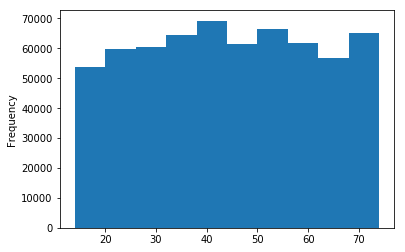

In [150]:
df_app_age.app_age_all.plot(kind='hist')

In [154]:
df_app_age.head()

,app_age_all,app_age_before_14,app_age_before_7
user_id_hash,,,
0013ae7e9f73194aeb0d350f1de1f441625825efe403c4c7d0a93c304fbf206f,57.0,43.0,50.0
0025a6c398e0ec7c471342188141853877f94a76b5127031cc673627dfa921de,70.0,56.0,63.0
002e3b6443aef897fc35486e072c5781d087943cdb9dff9fbe4eb39d525cc061,47.0,33.0,40.0
002e447aed33ed4c51a68743cc293ef2148058b6a6239e37d013cc6dc49bdfdf,51.0,37.0,44.0
005c9d79cf18efc6c8b5fa767964b1def9b8e2f8abd23f453310f60d69584a9f,58.0,44.0,51.0


In [151]:
df_ft_a = feather.read_dataframe('./Data/features_v4.feather').set_index('user_id_hash')
df_ft_7 = feather.read_dataframe('./Data/features_before_7_v4.feather').set_index('user_id_hash')
df_ft_14 = feather.read_dataframe('./Data/features_before_14_v4.feather').set_index('user_id_hash')

In [155]:
df_ft_a['app_age'] = df_app_age['app_age_all']
df_ft_a['app_age'].fillna(df_app_age['app_age_all'].mean(), inplace=True)

In [156]:
df_ft_7['app_age'] = df_app_age['app_age_before_7']
df_ft_7['app_age'].fillna(df_app_age['app_age_before_7'].mean(), inplace=True)

In [157]:
df_ft_14['app_age'] = df_app_age['app_age_before_14']
df_ft_14['app_age'].fillna(df_app_age['app_age_before_14'].mean(), inplace=True)

,num_session,last_active,receive_message,accept_message,life_time_value,num_purchase,avg_purchase,num_event,event_per_session,did_purchase_binary,...,last_date_event_6,last_date_event_60,last_date_event_61,last_date_event_62,last_date_event_63,last_date_event_64,last_date_event_7,last_date_event_9,num_devices,app_age
user_id_hash,,,,,,,,,,,,,,,,,,,,,
002e447aed33ed4c51a68743cc293ef2148058b6a6239e37d013cc6dc49bdfdf,3,33.0,0,0,0.0,0,0.0,119,39.666667,0.0,...,33.0,-1.0,-1.0,-1.0,-1.0,-1.0,43.0,-1.0,1,44.0
005c9d79cf18efc6c8b5fa767964b1def9b8e2f8abd23f453310f60d69584a9f,2,49.0,0,0,0.0,0,0.0,24,12.000000,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,51.0,-1.0,1,51.0
0061b4d30e8a9935b2ebeec954ff509b4f0cb500cd725c1aa7145841c82d907c,1,61.0,0,0,0.0,0,0.0,34,34.000000,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,61.0
00fbbf507c7d3c2f259cd3329d241c29d35712e2d4699f5c6a51d5149219ecee,3,58.0,0,0,0.0,0,0.0,47,15.666667,0.0,...,60.0,-1.0,-1.0,-1.0,-1.0,-1.0,60.0,-1.0,1,60.0
0107a0017873efc2dea9a9155832363ceacf6fe97bd428a73efa67b639962ac0,1,46.0,0,0,0.0,0,0.0,14,14.000000,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,46.0


In [165]:
feather.write_dataframe(df_ft_a.reset_index(), './Data/features_v4.feather')
feather.write_dataframe(df_ft_7.reset_index(), './Data/features_before_7_v4.feather')
feather.write_dataframe(df_ft_14.reset_index(), './Data/features_before_14_v4.feather')

## Convert absolute counts to frequency

Such as `num_session` to `session_per_day`

In [6]:
min_date = pd.to_datetime('2018-10-01 07:00:04.526000+00:00', utc=True)
cutoff_all = pd.to_datetime('2018-12-14 23:59:59.977000+00:00', utc=True)
cutoff_7 = cutoff_all - timedelta(days=7)
cutoff_14 = cutoff_all - timedelta(days=14)
min_date, cutoff_all, cutoff_7, cutoff_14

(Timestamp('2018-10-01 07:00:04.526000+0000', tz='UTC'),
 Timestamp('2018-12-14 23:59:59.977000+0000', tz='UTC'),
 Timestamp('2018-12-07 23:59:59.977000+0000', tz='UTC'),
 Timestamp('2018-11-30 23:59:59.977000+0000', tz='UTC'))

In [13]:
before_7_days = (cutoff_7 - min_date).days
before_14_days = (cutoff_14 - min_date).days
before_all_days = (cutoff_all - min_date).days

In [33]:
before_all_days, before_7_days, before_14_days

(74, 67, 60)

In [27]:
features = feather.read_dataframe('./Data/features_v4.feather')
features_7 = feather.read_dataframe('./Data/features_before_7_v4.feather')
features_14 = feather.read_dataframe('./Data/features_before_14_v4.feather')

In [28]:
features.columns

Index(['user_id_hash', 'num_session', 'last_active', 'receive_message',
       'accept_message', 'life_time_value', 'num_purchase', 'avg_purchase',
       'num_event', 'event_per_session', 'did_purchase_binary',
       'last_purchase', 'last_date_event_0', 'last_date_event_1',
       'last_date_event_10', 'last_date_event_11', 'last_date_event_14',
       'last_date_event_3', 'last_date_event_32', 'last_date_event_4',
       'last_date_event_40', 'last_date_event_41', 'last_date_event_42',
       'last_date_event_43', 'last_date_event_44', 'last_date_event_45',
       'last_date_event_47', 'last_date_event_48', 'last_date_event_49',
       'last_date_event_5', 'last_date_event_50', 'last_date_event_51',
       'last_date_event_52', 'last_date_event_54', 'last_date_event_55',
       'last_date_event_56', 'last_date_event_57', 'last_date_event_58',
       'last_date_event_59', 'last_date_event_6', 'last_date_event_60',
       'last_date_event_61', 'last_date_event_62', 'last_date_event_6

In [29]:
for col in ['num_event', 'num_session', 'receive_message', 'accept_message', 'num_purchase', 'life_time_value']:
    features[col+'_per_day'] = features[col]/before_all_days

In [30]:
features.head()

,user_id_hash,num_session,last_active,receive_message,accept_message,life_time_value,num_purchase,avg_purchase,num_event,event_per_session,...,last_date_event_7,last_date_event_9,num_devices,app_age,num_event_per_day,num_session_per_day,receive_message_per_day,accept_message_per_day,num_purchase_per_day,life_time_value_per_day
0,002e447aed33ed4c51a68743cc293ef2148058b6a6239e...,3,40,0,0,0.0,0,0.0,119,39.666667,...,50.0,-1.0,1,51.0,1.608108,0.040541,0.0,0.0,0.0,0.0
1,005c9d79cf18efc6c8b5fa767964b1def9b8e2f8abd23f...,2,56,0,0,0.0,0,0.0,24,12.000000,...,58.0,-1.0,1,58.0,0.324324,0.027027,0.0,0.0,0.0,0.0
2,0061b4d30e8a9935b2ebeec954ff509b4f0cb500cd725c...,1,68,0,0,0.0,0,0.0,34,34.000000,...,-1.0,-1.0,1,68.0,0.459459,0.013514,0.0,0.0,0.0,0.0
3,00fbbf507c7d3c2f259cd3329d241c29d35712e2d4699f...,3,65,0,0,0.0,0,0.0,47,15.666667,...,67.0,-1.0,1,67.0,0.635135,0.040541,0.0,0.0,0.0,0.0
4,0107a0017873efc2dea9a9155832363ceacf6fe97bd428...,1,53,0,0,0.0,0,0.0,14,14.000000,...,-1.0,-1.0,1,53.0,0.189189,0.013514,0.0,0.0,0.0,0.0


In [31]:
for col in ['num_event', 'num_session', 'receive_message', 'accept_message', 'num_purchase', 'life_time_value']:
    features_7[col+'_per_day'] = features_7[col]/before_7_days
    
features_7.head()

,user_id_hash,num_session,last_active,receive_message,accept_message,life_time_value,num_purchase,avg_purchase,num_event,event_per_session,...,last_date_event_7,last_date_event_9,num_devices,app_age,num_event_per_day,num_session_per_day,receive_message_per_day,accept_message_per_day,num_purchase_per_day,life_time_value_per_day
0,002e447aed33ed4c51a68743cc293ef2148058b6a6239e...,3,33.0,0,0,0.0,0,0.0,119,39.666667,...,43.0,-1.0,1,44.0,1.776119,0.044776,0.0,0.0,0.0,0.0
1,005c9d79cf18efc6c8b5fa767964b1def9b8e2f8abd23f...,2,49.0,0,0,0.0,0,0.0,24,12.000000,...,51.0,-1.0,1,51.0,0.358209,0.029851,0.0,0.0,0.0,0.0
2,0061b4d30e8a9935b2ebeec954ff509b4f0cb500cd725c...,1,61.0,0,0,0.0,0,0.0,34,34.000000,...,-1.0,-1.0,1,61.0,0.507463,0.014925,0.0,0.0,0.0,0.0
3,00fbbf507c7d3c2f259cd3329d241c29d35712e2d4699f...,3,58.0,0,0,0.0,0,0.0,47,15.666667,...,60.0,-1.0,1,60.0,0.701493,0.044776,0.0,0.0,0.0,0.0
4,0107a0017873efc2dea9a9155832363ceacf6fe97bd428...,1,46.0,0,0,0.0,0,0.0,14,14.000000,...,-1.0,-1.0,1,46.0,0.208955,0.014925,0.0,0.0,0.0,0.0


In [32]:
for col in ['num_event', 'num_session', 'receive_message', 'accept_message', 'num_purchase', 'life_time_value']:
    features_14[col+'_per_day'] = features_14[col]/before_14_days

In [34]:
feather.write_dataframe(features, './Data/features_v5.feather')
feather.write_dataframe(features_7, './Data/features_before_7_v5.feather')
feather.write_dataframe(features_14, './Data/features_before_14_v5.feather')